In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import joblib


In [7]:
# Load the first dataset
df1 = pd.read_csv('badmintondata.csv')

# Load the second dataset
df2 = pd.read_csv('badmintondata2.csv')

# Combine both datasets
df_combined = pd.concat([df1, df2], ignore_index=True)

# Count rows before cleaning
rows_before_cleaning = df_combined.shape[0]

# Handling missing values
df_combined = df_combined.dropna()  # Drop rows with missing values

# Handling outliers (Using z-score)
z_scores_combined = (df_combined - df_combined.mean()) / df_combined.std()  # Calculate z-scores
threshold = 3  # Set a threshold for outliers
outliers_combined = (z_scores_combined.abs() > threshold).any(axis=1)  # Find rows with outliers
df_combined_cleaned = df_combined[~outliers_combined].copy()  # Filter out rows with outliers

# Identify consecutive rows of all zeros
mask = (df_combined == 0).all(axis=1)
groups = mask.cumsum()

# Filter out consecutive rows of all zeros
df_combined_cleaned = df_combined[~mask]
df_combined_cleaned.to_csv('cleaned_dataset.csv', index = False)

# Count rows after cleaning
rows_after_cleaning = df_combined_cleaned.shape[0]

print("Number of rows before cleaning:", rows_before_cleaning)
print("Number of rows after cleaning:", rows_after_cleaning)


Number of rows before cleaning: 315200
Number of rows after cleaning: 168842


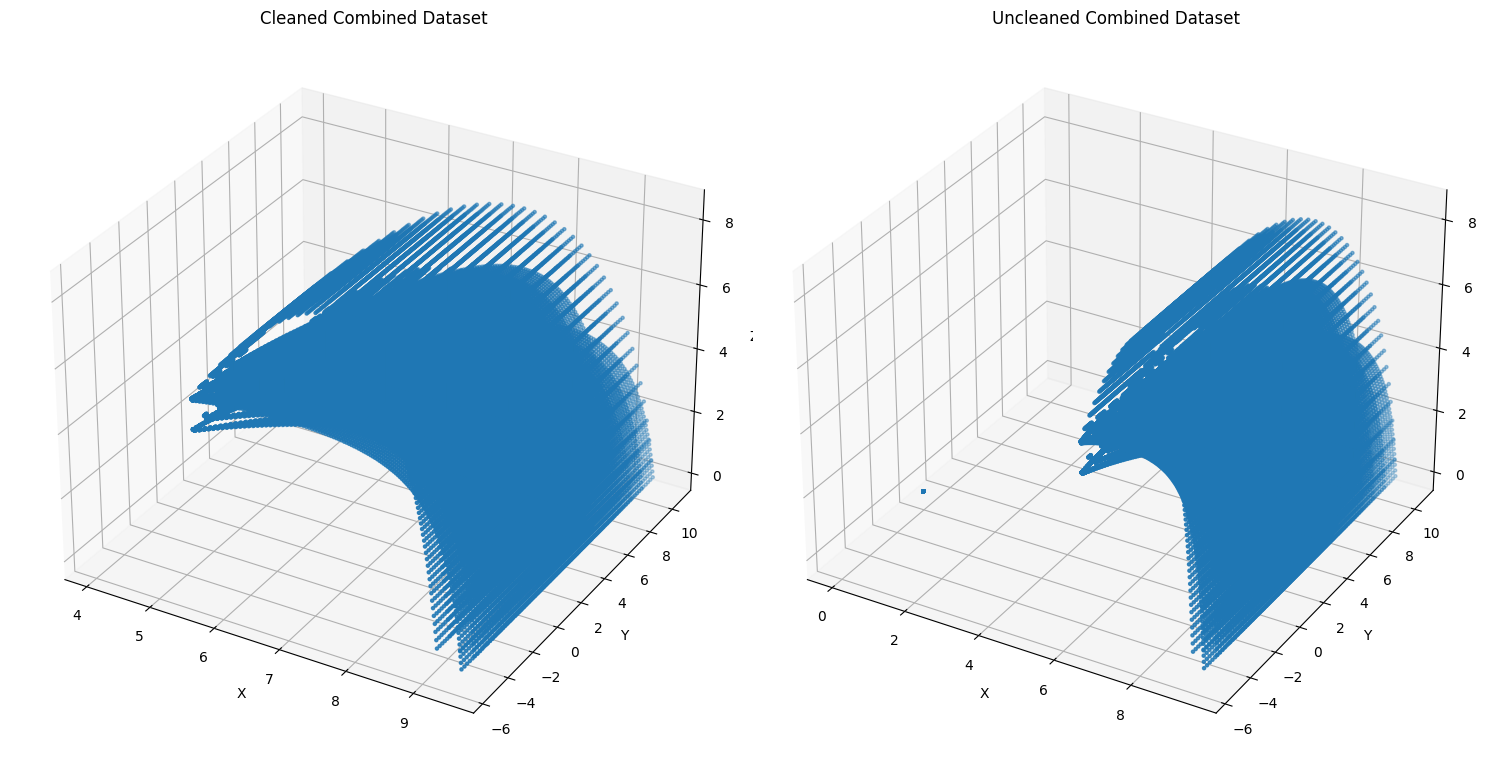

In [8]:
# Generate scatterplot for the cleaned combined dataset
fig, axes = plt.subplots(1, 2, figsize=(15, 8), subplot_kw={'projection': '3d'})

# Cleaned Combined Dataset
axes[0].scatter(df_combined_cleaned['SHUTTLECOCK POSITIION IN AIR(X) metres'], df_combined_cleaned['SHUTTLECOCK POSITIION IN AIR(Y) metres'], df_combined_cleaned['SHUTTLECOCK POSITIION IN AIR(Z) metres'], s=5)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].set_zlabel('Z')
axes[0].set_title('Cleaned Combined Dataset')
axes[0].grid(True)

# Uncleaned Combined Dataset
axes[1].scatter(df_combined['SHUTTLECOCK POSITIION IN AIR(X) metres'], df_combined['SHUTTLECOCK POSITIION IN AIR(Y) metres'], df_combined['SHUTTLECOCK POSITIION IN AIR(Z) metres'], s=5)
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].set_zlabel('Z')
axes[1].set_title('Uncleaned Combined Dataset')
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [9]:
# Group the data before each group of zeros
grouped_df = df_combined_cleaned.groupby(groups, group_keys=False)

# Function to add a Time field and SERVE_ID to a group
def add_time_and_serve_id(group):
    group['TIME'] = np.arange(len(group)) * 10  # Multiply by 10 to get time in ms
    group['SERVE_ID'] = group.name  # Assign the group name as the SERVE_ID

    # Reset time to 0 at the start of each group
    group.loc[group.index[0], 'TIME'] = 0
    
    return group

# Apply a TIME-based transformation and add SERVE_ID to each group
grouped_df = grouped_df.apply(add_time_and_serve_id)

# Extract unique groups
serve_ids = grouped_df['SERVE_ID'].unique()

# Split the groups into testing set and sample set (split into a testing set and a sample set using a 70:30 ratio)
train_groups, test_groups = train_test_split(serve_ids, test_size=0.3, random_state=42)

# Create the training set with highest point labels
train_data = []
for group in train_groups:
    group_data = grouped_df[grouped_df['SERVE_ID'] == group].copy()
    highest_point = group_data['SHUTTLECOCK POSITIION IN AIR(Z) metres'].max()
    group_data['HIGHEST_POINT'] = highest_point
    train_data.append(group_data)

train_df = pd.concat(train_data)

# Create the testing set with highest point labels
test_data = []
for group in test_groups:
    group_data = grouped_df[grouped_df['SERVE_ID'] == group].copy()
    highest_point = group_data['SHUTTLECOCK POSITIION IN AIR(Z) metres'].max()
    group_data['HIGHEST_POINT'] = highest_point
    test_data.append(group_data)

test_df = pd.concat(test_data)

# Print two groups from train_groups
print("Two groups from train_groups:")
for group in train_groups[:2]:
    print(f"Group: {group}")
    print(train_df[train_df['SERVE_ID'] == group])
    print("\n")

# Print two groups from test_groups
print("Two groups from test_groups:")
for group in test_groups[:2]:
    print(f"Group: {group}")
    print(test_df[test_df['SERVE_ID'] == group])
    print("\n")

Two groups from train_groups:
Group: 63153
        HUMAN PLAYER POSITION (X) metres  HUMAN PLAYER POSITION (Y) metres  \
155400                                 4                                 1   
155401                                 4                                 1   
155402                                 4                                 1   
155403                                 4                                 1   
155404                                 4                                 1   
...                                  ...                               ...   
155548                                 4                                 1   
155549                                 4                                 1   
155550                                 4                                 1   
155551                                 4                                 1   
155552                                 4                                 1   

        INITITAL VEL

In [13]:
import random

# Combine fields into a single dataframe
combined_group = pd.concat([train_df, test_df])

# Reset the index of the combined group
combined_group.reset_index(drop=True, inplace=True)

# Select two random groups from the combined group dataframe
random_groups = random.sample(list(combined_group['SERVE_ID'].unique()), 2)

# Print data for the randomly selected groups
for group_id in random_groups:
    group_data = combined_group.loc[combined_group['SERVE_ID'] == group_id]
    print(f"Group {group_id}:")
    print(group_data)
    print()


Group 69639:
       HUMAN PLAYER POSITION (X) metres  HUMAN PLAYER POSITION (Y) metres  \
44136                                 4                                 2   
44137                                 4                                 2   
44138                                 4                                 2   
44139                                 4                                 2   
44140                                 4                                 2   
...                                 ...                               ...   
44284                                 4                                 2   
44285                                 4                                 2   
44286                                 4                                 2   
44287                                 4                                 2   
44288                                 4                                 2   

       INITITAL VELOCITY OF SHUTTELCOCK(m/s)  \
44136         

In [12]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
import joblib

# Separate the features and target variable in the training set
X_train = train_df[["SHUTTLECOCK POSITIION IN AIR(X) metres", "SHUTTLECOCK POSITIION IN AIR(Y) metres", "SHUTTLECOCK POSITIION IN AIR(Z) metres"]]
y_train = train_df['HIGHEST_POINT']

print("Training the model...")
# Train the model
model = RandomForestRegressor()
model.fit(X_train, y_train)
print("Model training complete.")

# Separate the features and target variable in the testing set
X_test = test_df[["SHUTTLECOCK POSITIION IN AIR(X) metres", "SHUTTLECOCK POSITIION IN AIR(Y) metres", "SHUTTLECOCK POSITIION IN AIR(Z) metres"]]
y_test = test_df['HIGHEST_POINT']

print("Making predictions on the testing set...")
# Make predictions on the testing set
y_pred = model.predict(X_test)
print("Prediction complete.")

# Calculate performance indicators
r2 = model.score(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
cv_rmse = -np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error'))

print("Performance Indicators:")
print(f"R^2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"CV RMSE: {cv_rmse}")

# Export the model
joblib.dump(model, 'regression_model.joblib')
print("Model saved as regression_model.joblib.")


Training the model...


KeyboardInterrupt: 

In [ ]:
# Load the saved model
model = joblib.load('regression_model.joblib')

# Example test data with 3 features
test_data = [[2.5, 1.2, 3.8]]  # Update with your own test data

# Make predictions on the test data
predicted_highest_point = model.predict(test_data)

print("Predicted HIGHEST_POINT:", predicted_highest_point)


Predicted HIGHEST_POINT: [8.30603601]


c:\Users\yilin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Find the group with the closest accuracy to the predicted_highest_point
closest_group_id = None
min_difference = float('inf')

# Loop through the combined_group dataframe
for group_id in combined_group['SERVE_ID'].unique():
    group_data = combined_group[combined_group['SERVE_ID'] == group_id]
    group_highest_point = group_data['HIGHEST_POINT'].iloc[0]

    difference = abs(group_highest_point - predicted_highest_point)

    # Check if the current group has a smaller difference than the previous minimum
    if difference < min_difference:
        closest_group_id = group_id
        min_difference = difference

# Output the group data for the closest group
closest_group_data = combined_group[combined_group['SERVE_ID'] == closest_group_id]
print(f"Closest Group {closest_group_id}:")
print(closest_group_data)

# Find the index where the highest point is equal to SHUTTLECOCK POSITIION IN AIR(Z) meters
start_index = closest_group_data[closest_group_data['HIGHEST_POINT'] == closest_group_data['SHUTTLECOCK POSITIION IN AIR(Z) metres']].index[0]

# Get the row number by subtracting the first row index from the start_index
row_number = start_index - closest_group_data.index[0] + 1

print(f"Row Number: {row_number}")

# Get the time at the end of the group
end_time = closest_group_data['TIME'].iloc[-1]

# Get the time at the highest point
highest_point_time = closest_group_data['TIME'].iloc[row_number]

# Calculate the total time taken from the highest point to the end of the group
total_time = end_time - highest_point_time

print(f"Total Time (Highest Point to End): {total_time} ms")

# Get the maximum values for x, y, and z coordinates
max_x = max(
        max(closest_group_data['SHUTTLECOCK POSITIION IN AIR(X) metres'][row_number:]),
        max(closest_group_data['SHUTTLECOCK POSITIION IN AIR(X) metres'])
    )
max_y = max(
        max(closest_group_data['SHUTTLECOCK POSITIION IN AIR(Y) metres'][row_number:]),
        max(closest_group_data['SHUTTLECOCK POSITIION IN AIR(Y) metres'])
    )
max_z = max(
        max(closest_group_data['SHUTTLECOCK POSITIION IN AIR(Z) metres'][row_number:]),
        max(closest_group_data['SHUTTLECOCK POSITIION IN AIR(Z) metres'])
    )


Closest Group 138518:
       HUMAN PLAYER POSITION (X) metres  HUMAN PLAYER POSITION (Y) metres  \
91205                                 4                                 4   
91206                                 4                                 4   
91207                                 4                                 4   
91208                                 4                                 4   
91209                                 4                                 4   
91210                                 4                                 4   
91211                                 4                                 4   
91212                                 4                                 4   
91213                                 4                                 4   
91214                                 4                                 4   
91215                                 4                                 4   
91216                                 4               

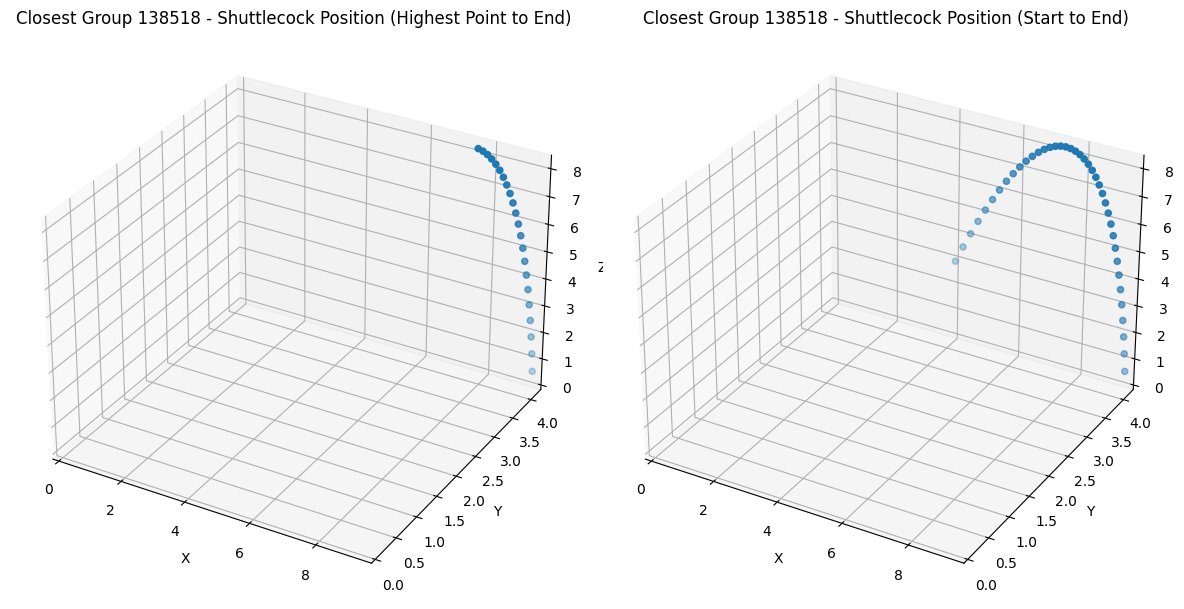

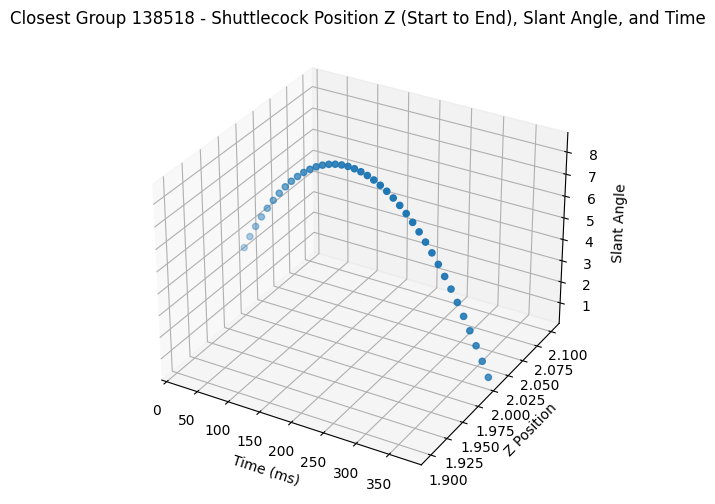

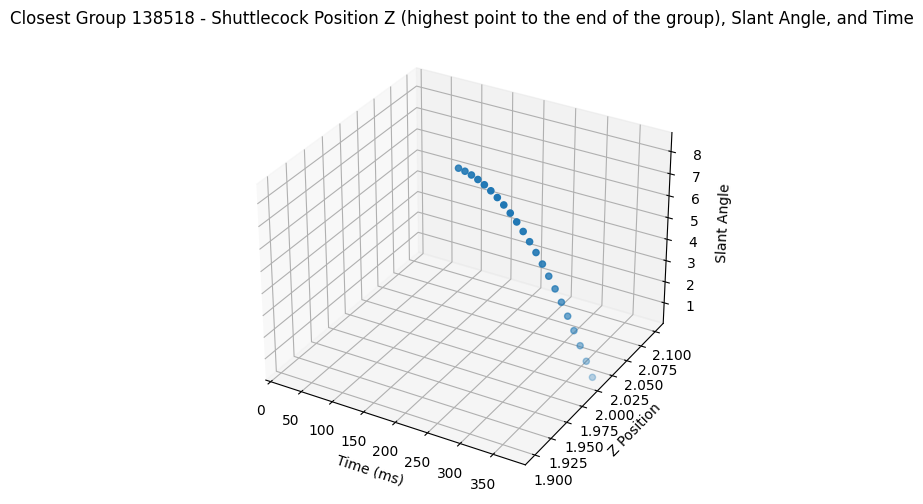

In [15]:
# Plot the shuttlecock position coordinates in 3D scatter plot from the highest point to the end of the group
fig = plt.figure(figsize=(12, 6))

# Plot fig1 - Shuttlecock Position (Highest Point to End)
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(
    closest_group_data['SHUTTLECOCK POSITIION IN AIR(X) metres'][row_number:],
    closest_group_data['SHUTTLECOCK POSITIION IN AIR(Y) metres'][row_number:],
    closest_group_data['SHUTTLECOCK POSITIION IN AIR(Z) metres'][row_number:]
)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title(f'Closest Group {closest_group_id} - Shuttlecock Position (Highest Point to End)')
ax1.set_xlim(0, max_x)
ax1.set_ylim(0, max_y)
ax1.set_zlim(0, max_z)

# Plot fig2 - Shuttlecock Position (Start to End)
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(
    closest_group_data['SHUTTLECOCK POSITIION IN AIR(X) metres'],
    closest_group_data['SHUTTLECOCK POSITIION IN AIR(Y) metres'],
    closest_group_data['SHUTTLECOCK POSITIION IN AIR(Z) metres']
)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title(f'Closest Group {closest_group_id} - Shuttlecock Position (Start to End)')
ax2.set_xlim(0, max_x)
ax2.set_ylim(0, max_y)
ax2.set_zlim(0, max_z)

plt.tight_layout()
plt.show()

# Plot the shuttlecock position Z, slant angle, and time in a 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax3 = fig.add_subplot(111, projection='3d')
ax3.set_xlim(0, closest_group_data['TIME'].max())
ax3.scatter(closest_group_data['TIME'], closest_group_data['SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)'], closest_group_data['SHUTTLECOCK POSITIION IN AIR(Z) metres'])
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Z Position')
ax3.set_zlabel('Slant Angle')
ax3.set_title(f'Closest Group {closest_group_id} - Shuttlecock Position Z (Start to End), Slant Angle, and Time')

# Plot the shuttlecock position Z, slant angle, and time in a 3D scatter plot (highest point to the end of the group)
fig = plt.figure(figsize=(10, 6))
ax4 = fig.add_subplot(111, projection='3d')
ax4.set_xlim(0, closest_group_data['TIME'].max())
ax4.scatter(closest_group_data['TIME'][row_number:], closest_group_data['SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)'][row_number:], closest_group_data['SHUTTLECOCK POSITIION IN AIR(Z) metres'][row_number:])
ax4.set_xlabel('Time (ms)')
ax4.set_ylabel('Z Position')
ax4.set_zlabel('Slant Angle')
ax4.set_title(f'Closest Group {closest_group_id} - Shuttlecock Position Z (highest point to the end of the group), Slant Angle, and Time')

plt.show()


c:\Users\yilin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Total Time (Highest Point to End): 210 ms
Moving the robot from (1, 2) to (2, 3)
Robot reached the predicted shuttlecock position.
Hitting back the shuttlecock at the highest point: 8.306152828240002
Robot's final position: (2, 3)
--------------------


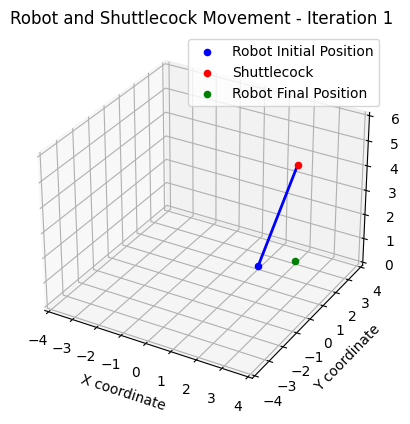

c:\Users\yilin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Total Time (Highest Point to End): 640 ms
Moving the robot from (-2, 3) to (1, -1)
Robot reached the predicted shuttlecock position.
Hitting back the shuttlecock at the highest point: 6.426401706260004
Robot's final position: (1, -1)
--------------------


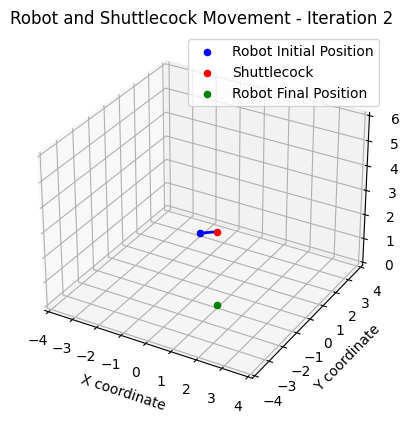

c:\Users\yilin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Total Time (Highest Point to End): 210 ms
Moving the robot from (0, 0) to (-3, 0)
Robot reached the predicted shuttlecock position.
Hitting back the shuttlecock at the highest point: 8.305947708159994
Robot's final position: (-3, 0)
--------------------


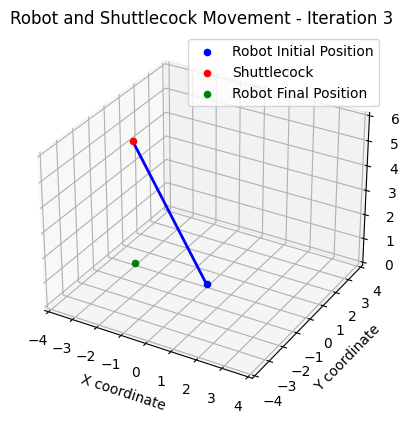

In [16]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import joblib

# Load the trained regression model
model = joblib.load('regression_model.joblib')

# Define the robot's movement capability
robot_speed = 3  # meters per 1.5 seconds

# Generate random positions for the robot and shuttlecock
robot_positions = [
    (1, 2),
    (-2, 3),
    (0, 0)
]
shuttlecock_positions = [
    (2, 3, 4),
    (1, -1, 3),
    (-3, 0, 5)
]

# Create a separate 3D plot for each iteration
for i in range(len(shuttlecock_positions)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Predict the highest point of the shuttlecock for each position
    predicted_highest_point = model.predict([shuttlecock_positions[i]])

    # Find the group with the closest accuracy to the predicted highest point
    closest_group_id = None
    min_difference = float('inf')

    # Loop through the combined_group dataframe
    for group_id in combined_group['SERVE_ID'].unique():
        group_data = combined_group[combined_group['SERVE_ID'] == group_id]
        group_highest_point = group_data['HIGHEST_POINT'].iloc[0]

        difference = abs(group_highest_point - predicted_highest_point)

        # Check if the current group has a smaller difference than the previous minimum
        if difference < min_difference:
            closest_group_id = group_id
            min_difference = difference

    # Output the group data for the closest group
    closest_group_data = combined_group[combined_group['SERVE_ID'] == closest_group_id]
    # print(closest_group_data)  # Uncomment this line to see the full data

    # Find the index where highest point is equal to SHUTTLECOCK POSITIION IN AIR(Z) metres
    start_index = closest_group_data[closest_group_data['HIGHEST_POINT'] == closest_group_data['SHUTTLECOCK POSITIION IN AIR(Z) metres']].index[0]

    # Get the row number by subtracting the first row index from the start_index
    row_number = start_index - closest_group_data.index[0] + 1

    # Calculate the total time taken from the highest point to the end of the group
    end_time = closest_group_data['TIME'].iloc[-1]
    highest_point_time = closest_group_data['TIME'].iloc[row_number]
    total_time = end_time - highest_point_time
    print(f"Total Time (Highest Point to End): {total_time} ms")

    predicted_highest_point = predicted_highest_point[0]
    robot_position = robot_positions[i]

    # Calculate the time needed for the robot to reach the predicted shuttlecock position
    distance = np.sqrt(np.sum(np.square(np.array(shuttlecock_positions[i][:2]) - np.array(robot_position))))
    travel_time = distance / robot_speed

    # Move the robot to the predicted shuttlecock position
    print("Moving the robot from", robot_position, "to", shuttlecock_positions[i][:2])

    # Plot the robot's movement
    ax.plot([robot_position[0], shuttlecock_positions[i][0]], [robot_position[1], shuttlecock_positions[i][1]], [0, shuttlecock_positions[i][2]], color='blue', linestyle='-', linewidth=2)

    # Plot the robot's initial position
    ax.scatter(robot_position[0], robot_position[1], 0, color='blue', marker='o', label='Robot Initial Position')

    # Plot the shuttlecock's initial and highest point
    ax.scatter(shuttlecock_positions[i][0], shuttlecock_positions[i][1], shuttlecock_positions[i][2], color='red', marker='o', label='Shuttlecock')

    time.sleep(travel_time)
    print("Robot reached the predicted shuttlecock position.")

    # Check if the robot reached the predicted position before the total time
    if travel_time <= total_time:
        # Hit back the shuttlecock
        print("Hitting back the shuttlecock at the highest point:", predicted_highest_point)
        time.sleep(1.5)  # Assuming it takes 1.5 seconds to hit back the shuttlecock

        # Print the robot's final position after hitting back the shuttlecock
        robot_final_position = shuttlecock_positions[i][:2]  # Assuming the robot stays at the x-y position
        print("Robot's final position:", robot_final_position)

        # Plot the robot's final position
        ax.scatter(robot_final_position[0], robot_final_position[1], 0, color='green', marker='o', label='Robot Final Position')

        print("--------------------")
    else:
        print("Robot could not reach the predicted position within the total time.")

    # Set plot title and labels
    ax.set_title(f'Robot and Shuttlecock Movement - Iteration {i+1}')
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_zlabel('Z coordinate')

    # Set plot limits
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    ax.set_zlim([0, 6])

    # Add legend
    ax.legend()

    # Display the plot
    plt.show()


# Hyperparameter Tuning 
Experiment with different hyperparameters of the RandomForestRegressor to find the combination that yields better performance. You can use techniques like grid search or random search to explore the hyperparameter space and find optimal values. Adjusting parameters such as the number of estimators, max depth, or min samples leaf can significantly impact the model's accuracy.

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import joblib

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Initialize the Random Forest Regressor
model = RandomForestRegressor()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters
print("Best Parameters:", best_params)

# Train the best model
best_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = best_model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse)

# Calculate R2 score (coefficient of determination)
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

# Use cross-validation for more robust evaluation
cv_rmse = -cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("Cross-validated RMSE:", cv_rmse.mean())

# Export the best model
joblib.dump(best_model, 'regression_model.joblib')
